<a href="https://colab.research.google.com/github/Afsaumutoniwase/Farmsmart_model_training_and_evaluation/blob/main/Summative_Intro_to_ml_Afsa%20Umutoniwase_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization Techniques in Machine Learning

Objective: This assignment aims to explore implementation or Machine Learning Models with regularization, optimization and Error analysis  techniques used in machine learning to improve models' performance, convergence speed, and efficiency..

A Notebook detailing the following

* Project name
* Clear out puts from cells






**Instructions**

1. Acquire a dataset suitable for ML tasks as per your proposal.
2. Implement a simple machine learning model based on neural networks on the chosen dataset without any defined optimization techniques. (Check instructions)
3. Implement and compare the model's performance after applying 3 to 4 disntict combinations regularization and optimization techniques.
4. Discuss the results on the README file.
5. Make predictions using test data
7. Implement error analysis techniques and ensure there is: F1-Score, Recall, Precision, RUC a confusion matrix using plotting libraries (not verbose)

Submit notebook to github repo



## Optimization Techniques in Machine Learning – FarmSmart leaf health classifier

This notebook implements binary image classification for hydroponically grown plants, predicting leaf health (healthy vs unhealthy) using CNN models. The goal is to explore the impact of optimization and regularization techniques on model performance, efficiency, and convergence.



# Case Study and Implementation




In [2]:
#Import Necessary Libraries
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Farmsmart_model_training_and_evaluation/Dataset_HydroFarm'
os.makedirs('saved_models', exist_ok=True)

Mounted at /content/drive


# The Dataset
> ***Brief Description:***
State the Problem and A short Description of the data


In [4]:
img_size = (240, 240)
batch_size = 32

train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    data_dir + '/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    data_dir + '/validation',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    data_dir + '/test',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 371 images belonging to 2 classes.
Found 82 images belonging to 2 classes.
Found 77 images belonging to 2 classes.


#SECTION 1: Model Architecture:



```
TODO: Insert an image with the Model architecture here.Replace the image Below
```
> <img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*v1ohAG82xmU6WGsG2hoE8g.png" alt="?" style="width:25px"/>




#Task: Define a function that creates models without and With specified Optimization techniques


In [5]:
def define_model(optimizer_name='adam',
                 regularization_type=None,
                 early_stopping=False,
                 dropout=0.0,
                 learning_rate=0.001,
                 epochs=10,
                 train_data=None,
                 val_data=None):

    # Define regularizer
    regularizer = None
    if regularization_type == 'l1':
        regularizer = l1(0.01)
    elif regularization_type == 'l2':
        regularizer = l2(0.01)

    # Choose optimizer
    if optimizer_name.lower() == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name.lower() == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer. Use 'adam' or 'rmsprop'.")

    # Build model
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(240, 240, 3), kernel_regularizer=regularizer))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizer))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizer))

    if dropout > 0:
        model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Callbacks
    callbacks = []
    if early_stopping:
        callbacks.append(EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True))

    # Train model
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        callbacks=callbacks
    )

    return model, history


In [6]:
model1, history1 = define_model(
    optimizer_name='adam',
    regularization_type= None,
    early_stopping=True,
    dropout=0,
    learning_rate=0.0005,
    epochs=10,
    train_data=train_gen,
    val_data=val_gen
)
model1.save('saved_models/model1_baseline.h5')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 94s 8s/step - accuracy: 0.5178 - loss: 3.0219 - val_accuracy: 0.6829 - val_loss: 0.7379
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 58s 5s/step - accuracy: 0.7443 - loss: 0.5193 - val_accuracy: 0.7927 - val_loss: 0.4485
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 0.8900 - loss: 0.2909 - val_accuracy: 0.9146 - val_loss: 0.2847
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.9670 - loss: 0.1936 - val_accuracy: 0.9634 - val_loss: 0.2072
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 0.9916 - loss: 0.1067 - val_accuracy: 0.9634 - val_loss: 0.1313
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 0.9982 - loss: 0.0474 - val_accuracy: 0.9634 - val_loss: 0.1309
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 1.0000 - loss: 0.0267 - val_accuracy: 0.9634 - val_loss: 0.1389
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 1.0000 - loss: 0.0113 - val_accuracy: 0.9634 - val_loss:

# Task: Print out the Final Model Accuracy and plot the Loss curve

In [7]:
def loss_curve_plot(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'r^-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [8]:
def evaluate_model(model, test_gen):
    preds = model.predict(test_gen)
    y_pred = np.round(preds).astype(int)
    y_true = test_gen.classes

    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks([0, 1], ['Unhealthy', 'Healthy'])
    plt.yticks([0, 1], ['Unhealthy', 'Healthy'])
    plt.show()

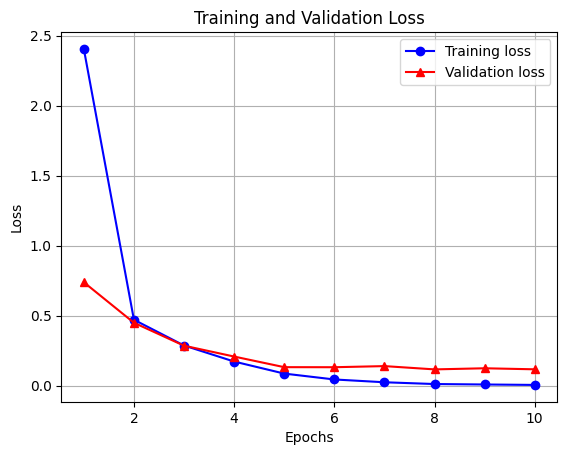

In [9]:
loss_curve_plot(history1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97        38
           1       0.95      1.00      0.97        39

    accuracy                           0.97        77
   macro avg       0.98      0.97      0.97        77
weighted avg       0.98      0.97      0.97        77



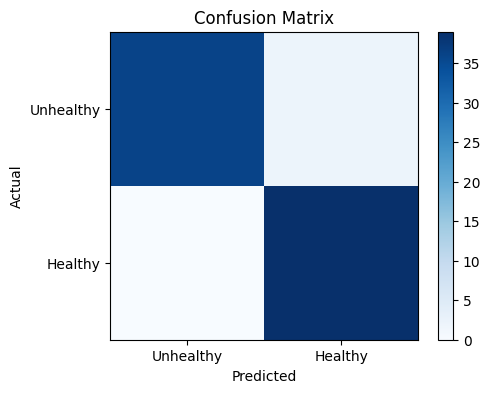

In [10]:
evaluate_model(model1, test_gen)

# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 61s 4s/step - accuracy: 0.5214 - loss: 2.9616 - val_accuracy: 0.6829 - val_loss: 0.6161
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.7986 - loss: 0.4816 - val_accuracy: 0.8902 - val_loss: 0.2793
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.9621 - loss: 0.1708 - val_accuracy: 0.9268 - val_loss: 0.2249
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 0.9728 - loss: 0.1314 - val_accuracy: 0.9512 - val_loss: 0.1070
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.9970 - loss: 0.0310 - val_accuracy: 0.9634 - val_loss: 0.1104
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.9991 - loss: 0.0115 - val_accuracy: 0.9634 - val_loss: 0.1867
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 1.0000 - loss: 0.0078 - val_accuracy: 0.9634 - val_loss: 0.1204


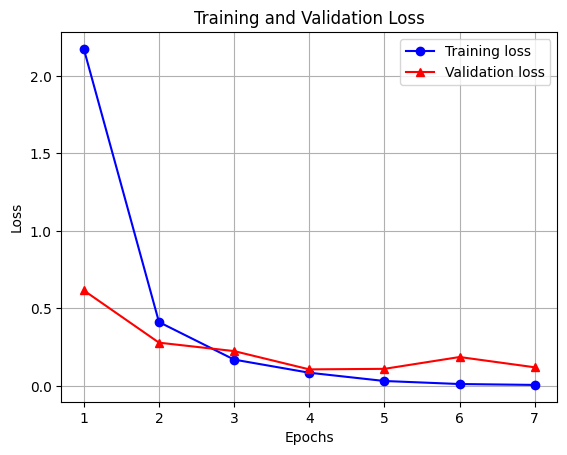

3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        38
           1       0.93      1.00      0.96        39

    accuracy                           0.96        77
   macro avg       0.96      0.96      0.96        77
weighted avg       0.96      0.96      0.96        77



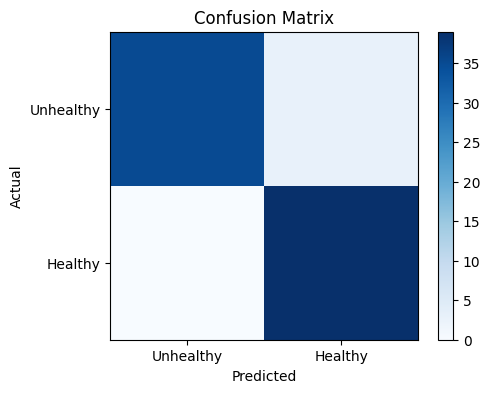

In [11]:
model2, history2 = define_model(
    optimizer_name='adam',
    regularization_type= None,
    early_stopping=True,
    dropout=0.3,
    learning_rate=0.001,
    epochs=10,
    train_data=train_gen,
    val_data=val_gen
)
model2.save('saved_models/model2_adam&dropout.h5')

loss_curve_plot(history2)
evaluate_model(model2, test_gen)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - accuracy: 0.5207 - loss: 5.1743 - val_accuracy: 0.5122 - val_loss: 2.5036
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.5704 - loss: 2.3038 - val_accuracy: 0.7439 - val_loss: 1.7481
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.7260 - loss: 1.6071 - val_accuracy: 0.7561 - val_loss: 1.3367
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step - accuracy: 0.7792 - loss: 1.2302 - val_accuracy: 0.7439 - val_loss: 1.0482
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.8092 - loss: 0.9446 - val_accuracy: 0.5244 - val_loss: 1.1918
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.7978 - loss: 0.9085 - val_accuracy: 0.8171 - val_loss: 0.8451
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step - accuracy: 0.8512 - loss: 0.7690 - val_accuracy: 0.8049 - val_loss: 0.7575
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - accuracy: 0.8763 - loss: 0.6955 - val_accuracy: 0.8902 - val_loss:

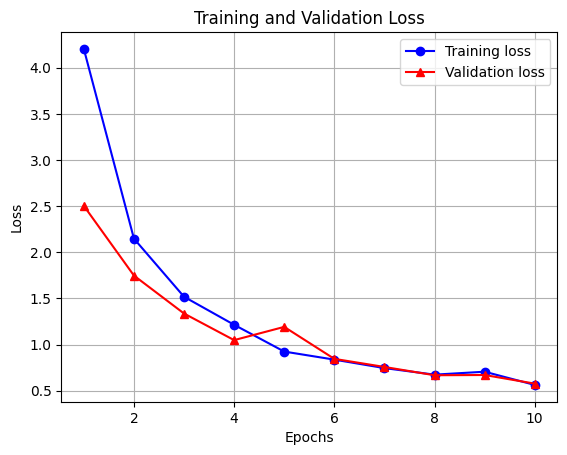

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 870ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.82      0.89        38
           1       0.84      0.97      0.90        39

    accuracy                           0.90        77
   macro avg       0.91      0.90      0.90        77
weighted avg       0.91      0.90      0.90        77



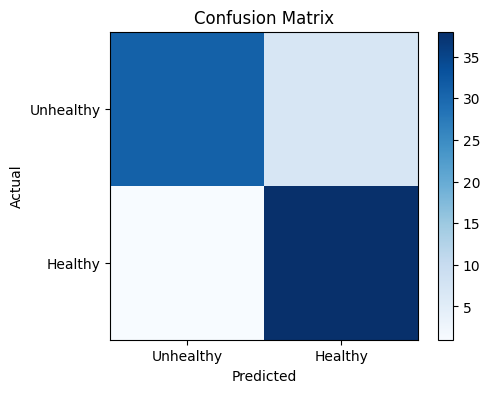

In [12]:
model3, history3 = define_model(
    optimizer_name='rmsprop',
    regularization_type='l2',
    early_stopping=True,
    dropout=0,
    learning_rate=0.0005,
    epochs=10,
    train_data=train_gen,
    val_data=val_gen
)

loss_curve_plot(history3)
evaluate_model(model3, test_gen)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 64s 5s/step - accuracy: 0.5099 - loss: 3.7707 - val_accuracy: 0.6829 - val_loss: 2.7258
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - accuracy: 0.5845 - loss: 2.7152 - val_accuracy: 0.6707 - val_loss: 2.1586
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.7310 - loss: 2.0370 - val_accuracy: 0.7439 - val_loss: 1.8201
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.7420 - loss: 1.7273 - val_accuracy: 0.7439 - val_loss: 1.6354
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - accuracy: 0.8191 - loss: 1.5371 - val_accuracy: 0.8171 - val_loss: 1.4871
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.7986 - loss: 1.4481 - val_accuracy: 0.7439 - val_loss: 1.4304
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.8201 - loss: 1.3270 - val_accuracy: 0.7805 - val_loss: 1.3607
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 55s 5s/step - accuracy: 0.8268 - loss: 1.2872 - val_accuracy: 0.7927 - val_loss:

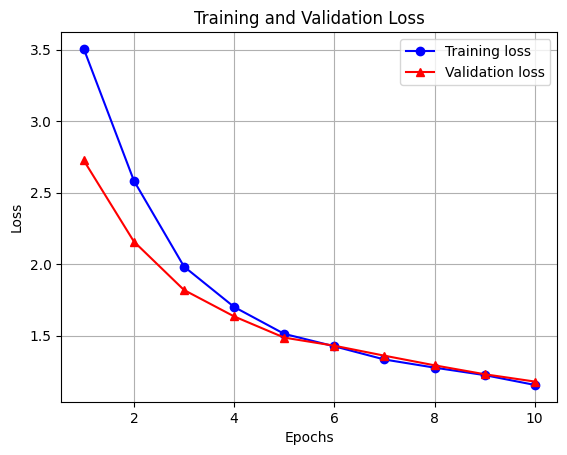

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.82      0.85        38
           1       0.83      0.90      0.86        39

    accuracy                           0.86        77
   macro avg       0.86      0.86      0.86        77
weighted avg       0.86      0.86      0.86        77



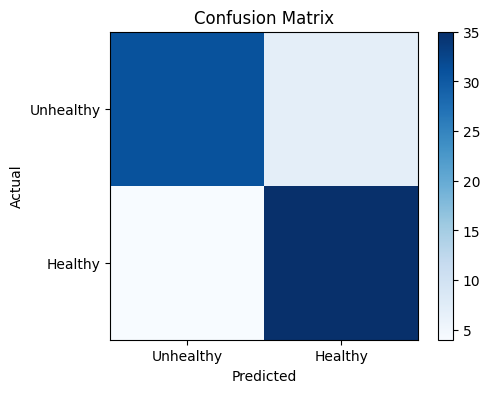

In [13]:
model4, history4 = define_model(
    optimizer_name='adam',
    regularization_type='l2',
    early_stopping=True,
    dropout=0.5,
    learning_rate=0.0001,
    epochs=10,
    train_data=train_gen,
    val_data=val_gen
)

loss_curve_plot(history4)
evaluate_model(model4, test_gen)

In [14]:
model1.save('saved_models/model1_baseline.h5')
model2.save('saved_models/model2_adam&dropout.h5')
model3.save('saved_models/model3_rmsprop&l2.h5')
model4.save('saved_models/model4_adam&l2.h5')

#Task: Make Predictions using the best saved model


Create a confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible

Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

In [15]:
model1 = load_model('saved_models/model1_baseline.h5')
model2 = load_model('saved_models/model2_adam&dropout.h5')
model3 = load_model('saved_models/model3_rmsprop&l2.h5')
model4 = load_model('saved_models/model4_adam&l2.h5')

def evaluate_best_model(model, test_data):
    loss, accuracy = model.evaluate(test_data)
    print(f"Accuracy: {accuracy:.4f} | Loss: {loss:.4f}")
    return accuracy, loss

results = {}
results['model1'] = evaluate_best_model(model1, test_gen)
results['model2'] = evaluate_best_model(model2, test_gen)
results['model3'] = evaluate_best_model(model3, test_gen)
results['model4'] = evaluate_best_model(model4, test_gen)

best_model_name = max(results, key=lambda k: results[k][0])
print(f"\n Best Performing Model: {best_model_name} with Accuracy = {results[best_model_name][0]:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9792 - loss: 0.1168
Accuracy: 0.9740 | Loss: 0.1337
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.9610 - loss: 0.1171
Accuracy: 0.9610 | Loss: 0.1211
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step - accuracy: 0.8856 - loss: 0.6394
Accuracy: 0.8961 | Loss: 0.6281


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8544 - loss: 1.1815
Accuracy: 0.8571 | Loss: 1.1607

 Best Performing Model: model1 with Accuracy = 0.9740


In [16]:
probs = model1.predict(test_gen)
print(probs[:10])  # Should show floats like 0.23, 0.78 etc.


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 612ms/step
[[0.0203288 ]
 [0.00427722]
 [0.01887674]
 [0.00935479]
 [0.19028567]
 [0.19028567]
 [0.01228261]
 [0.01228261]
 [0.00739058]
 [0.01085763]]


In [19]:

def make_predictions(model_path, X):
    # Load the model from the specified path
    model = load_model(model_path)

    # Make predictions (probabilities between 0 and 1)
    probs = model.predict(X)

    # Convert probabilities to binary class labels (0 or 1)
    predictions = (probs > 0.2).astype(int)
    return predictions

best_model_path = 'saved_models/model1_baseline.h5'
preds = make_predictions(best_model_path, test_gen)
test_labels = test_gen.classes
print("Unhealthy:", sum(test_labels == 0), "Healthy:", sum(test_labels == 1))

# View some results
print(preds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
Unhealthy: 38 Healthy: 39
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]


Congratulations!!
